# Segmentation: example from torchvision

We have seen in previous chapters the basics of PyTorch and how to train a simple network. As this course is rather meant to help you *use* networks rather than *train* them, we won't be repeating the training process for other DL modalities. Rather, we will use pre-trained network and see how we should format inputs, how to use outputs etc.

## Semantic segmentation

Until now we have only seen classification i.e. an image gets summarized to a single number corresponding to a category. The other main class of tasks done in Computer Vision is segmentation i.e. detection of objects in images. There are different types of segmentation: single class segmentation where only one type of object is detected, semantic segmentation where all pixels belonging to objects of a given type are assigned a given class, instance segmentation where each object gets assigned a given class etc.

Here we first look at semantic segmentation using a classical convolutional network called ResNet. This network can be found pre-trained in the torchivision library trained on standard datasets. We copied the example below from that library [here](https://pytorch.org/vision/stable/models.html#semantic-segmentation). Let's run it part by part.

### Image and model import

First we of course need to load an image and the chosen model. Models are imported first from the library as models:

In [1]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

img = read_image("../data/woody_baille.JPG")

We see that we import both a model ```fcn_resnet50``` and a weights object ```FCN_ResNet50_Weights```. The model defines the architecture, i.e. the sequence of layers, while the weigths are the values of all the parameters in the model that have been pre-trained on a given dataset. We can now initialize the weights with default values and load those weights into the model:

In [2]:
# Step 1: Initialize model with the best available weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

The last command prints out the model. We see that it is composed of many parts. Importantly, we can check the first and last layer. In the first layer we see that the model expects three channels: this is a model trained on natural images with RGB channels. Then the last layer: ```Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))```. So the last layer is a convolutional layer with 21 outputs. Unlike in classifiers where a list of numbers (probabilities of classes is output) here the output will be an image composed of 21 channels. Essentially, segmentation is classification task for each single pixel. At the end we get 21 images containing the probabilities for each pixel to belong to one of the 21 categories. Why 21? 

In [3]:
FCN_ResNet50_Weights.DEFAULT

FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1

We see that the default weights correspond to the VOC training, a standard Computer Vision challenge using 20 categories of objects (plus background):
- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor


### Pre-processing

Then we need to make sure that we are going to feed the network the appropriate data. First we need to normalize our images with the same weights used during training. For this we load a transform that will take care of this for us:

In [4]:
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

Then we need to apply the transform to our image. Note that our images are RGB images, so their dimensions are C x H y W where the two last dimensions are just pixel dimensions. With three dimensions, the model will assume that we actually have a **a batch of size 3 for gray scale images**. So we need to add a dummy dimension in the first position to create a batch of size 1:

In [5]:
# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

/Users/gw18g940/mambaforge/envs/dslpytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
batch.shape

torch.Size([1, 3, 520, 693])

### Prediction

Finally we can run inference with our model. This particular model as multiple outputs and we just need the ```out``` element:

In [7]:
prediction = model(batch)['out']

In [8]:
prediction.shape

torch.Size([1, 21, 520, 693])

So now the size of our output is indeed an image with 21 channels. What we want is a single-channel image where the value of each pixel indicates its class. As the pixel values are not normalized, we compute the softmax value for each "column of 21 pixels" to get actual probabilities:

In [9]:
# Step 4: Use the model and visualize the prediction
normalized_masks = prediction.softmax(dim=1)

In [10]:
normalized_masks.shape

torch.Size([1, 21, 520, 693])

Now we can check for each pixel which channel has the largest values, i.e. largest probability and use that channel index as value in our image: 

In [11]:
pixel_class = normalized_masks.argmax(axis=1)

In [12]:
import matplotlib.pyplot as plt

In [13]:
pixel_class.shape

torch.Size([1, 520, 693])

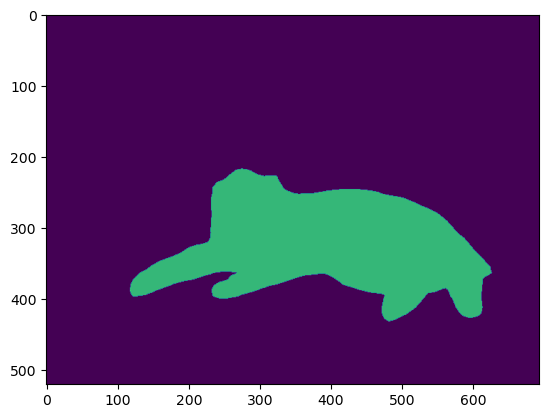

In [14]:
plt.imshow(pixel_class[0].detach().numpy());

In [15]:
pixel_class.unique()

tensor([ 0,  8, 12])

In [16]:
import torch
[torch.sum(pixel_class == x) for x in pixel_class.unique()]

[tensor(303566), tensor(56793), tensor(1)]

If we check our pixel classes, we see that we have only three types of pixels and that after value 0 (background) the majority has index 8. We can have a look at the weights metadata:

In [17]:
weights.meta["categories"]

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

and see that index 8 indeed corresponds to cats:

In [59]:
weights.meta["categories"][8]

'cat'